In [1]:
import torch
import os
import numpy as np
from model import load_model, detect
from inputs import sports_input
from baseline import BaselineAttack
from discrete_alteration import DiscreteAlterations
from paraphrasing import ParaphrasingAttack
from tokenization import TokenizationAttack
import matplotlib.pyplot as plt


/Users/alexandernemecek/Desktop/github/Topic-Based-LLM-Watermarks/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('./watermarked_outputs/sports_watermarked.txt', 'r') as file:
    content = file.read()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_token_mappings():
    total_tokens = 100000
    topics = ["sports", "animals", "technology", "music", "medicine"]
    topic_token_mapping = {topic: [] for topic in topics}

    for i in range(total_tokens):
        topic_index = i % len(topics)
        topic = topics[topic_index]
        topic_token_mapping[topic].append(i)
    return topic_token_mapping
token_mappings = get_token_mappings()

args = {
    'demo_public': False, 
    'model_name_or_path': 'facebook/opt-1.3b', 
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    'use_gpu': True, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 2.5, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
    'is_topic': False,
    'topic_token_mapping': token_mappings,
    'detected_topic': "",
}

In [3]:
input_text = sports_input()
model, tokenizer = load_model(args)

input_prompt = input_text + content

without_watermark_detection_result = detect(input_prompt, content, 
                                        args, 
                                        device=device, 
                                        tokenizer=tokenizer)


print(f"Original Detection: \n{without_watermark_detection_result}")
for item in without_watermark_detection_result:
    if len(item) > 0:
        if item[0] == 'z-score':
            original_z_score = float(item[1])
        elif item[0] == 'Tokens Counted (T)':
            total_tokens = int(item[1])

Original Detection: 
[['Tokens Counted (T)', '199'], ['# Tokens in Greenlist', '94'], ['Fraction of T in Greenlist', '47.2%'], ['z-score', '7.24'], ['p value', '2.18e-13'], ['z-score Threshold', '2.5'], ['Prediction', 'Watermarked'], ['Confidence', '100.000%'], []]


In [18]:
baseline = BaselineAttack()
n_modifications = list(range(0, 51, 2))

z_score_results = {'insertion': [], 'deletion': [], 'substitution': [], 'combination': [], 'inference_insertion': [], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}
robustness_scores = {'insertion': [], 'deletion': [], 'substitution': [], 'combination': [], 'inference_insertion': [], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}

def evaluate_attack(attack_type, n_edits, inference=False):
    if attack_type == 'insertion':
        if inference:
            attacked_text = baseline.inference_modify_text(content, n_edits, edit_type='insert')
        else:
            attacked_text = baseline.modify_text(content, n_edits, edit_type='insert')
    elif attack_type == 'deletion':
        if inference:
            attacked_text = baseline.inference_modify_text(content, n_edits, edit_type='delete')
        else:
            attacked_text = baseline.modify_text(content, n_edits, edit_type='delete')
    elif attack_type == 'substitution':
        if inference:
            attacked_text = baseline.inference_modify_text(content, n_edits, edit_type='substitute')
        else:
            attacked_text = baseline.modify_text(content, n_edits, edit_type='substitute')
    elif attack_type == 'combination':
        if inference:
            attacked_text = baseline.combination_modify_text(content, insertion_n_edits=n_edits//3, insertion_is_inferenced=True, deletion_n_edits=n_edits//3, deletion_is_inferenced=True, substitution_n_edits=n_edits//3, substitution_is_inferenced=True)
        else:
            attacked_text = baseline.combination_modify_text(content, insertion_n_edits=n_edits//3, deletion_n_edits=n_edits//3, substitution_n_edits=n_edits//3)
    return attacked_text

for n in n_modifications:
    print(n)
    for attack_type in ['insertion', 'deletion', 'substitution', 'combination']:
        print(attack_type)
        attacked_text = evaluate_attack(attack_type, n)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        print('detection finished')

        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[attack_type].append(z_score)
        print(z_score_results)

        if n > 0:  
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0

        robustness_scores[attack_type].append(robustness_score)

        inference_attack_type = f'inference_{attack_type}'
        attacked_text = evaluate_attack(attack_type, n, inference=True)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[inference_attack_type].append(z_score)
        if n > 0:
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0
        robustness_scores[inference_attack_type].append(robustness_score)

0
insertion
detection finished
{'insertion': [7.36], 'deletion': [], 'substitution': [], 'combination': [], 'inference_insertion': [], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}
deletion
detection finished
{'insertion': [7.36], 'deletion': [7.36], 'substitution': [], 'combination': [], 'inference_insertion': [7.36], 'inference_deletion': [], 'inference_substitution': [], 'inference_combination': []}
substitution
detection finished
{'insertion': [7.36], 'deletion': [7.36], 'substitution': [7.36], 'combination': [], 'inference_insertion': [7.36], 'inference_deletion': [7.36], 'inference_substitution': [], 'inference_combination': []}
combination
detection finished
{'insertion': [7.36], 'deletion': [7.36], 'substitution': [7.36], 'combination': [7.24], 'inference_insertion': [7.36], 'inference_deletion': [7.36], 'inference_substitution': [7.36], 'inference_combination': []}
2
insertion
detection finished
{'insertion': [7.36, 7.57], 'deletion': [7.

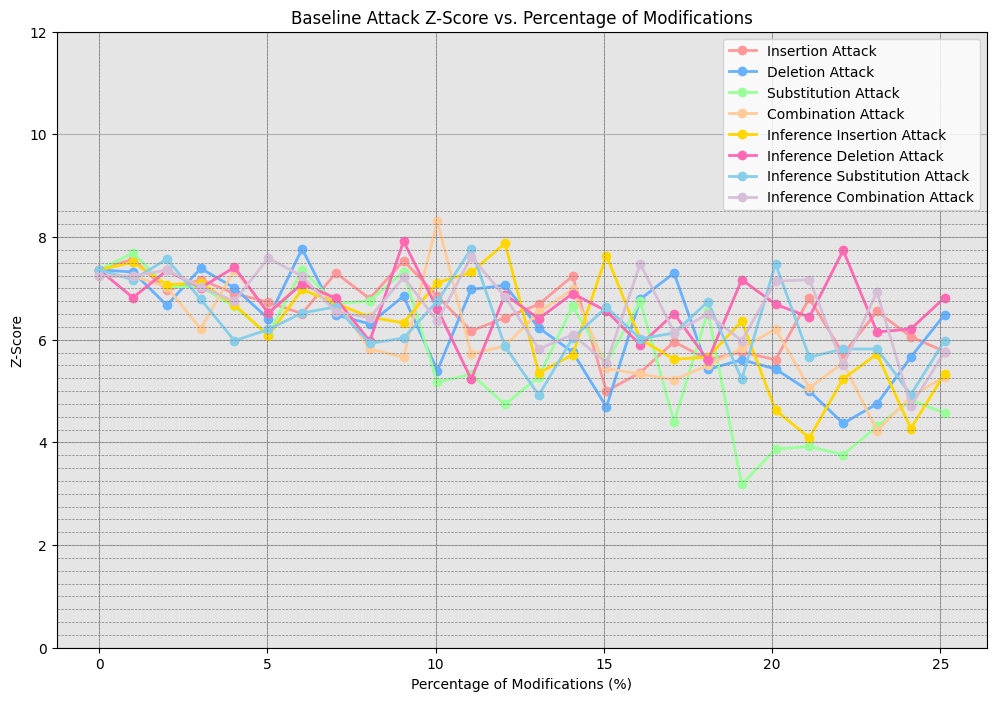

In [19]:
plt.figure(figsize=(12, 8))
colors = [
    '#FF9999', '#66B2FF', '#99FF99', '#FFCC99',
    '#FFD700', '#FF69B4', '#87CEEB', '#D8BFD8'
]

for i, (attack_type, z_scores) in enumerate(z_score_results.items()):
    percentage_modifications = [(modifications / total_tokens) * 100 for modifications in n_modifications]
    plt.plot(percentage_modifications, z_scores, 
             label=f'{attack_type.replace("_", " ").title()} Attack',
             color=colors[i % len(colors)], 
             marker='o', 
             linewidth=2,
             markersize=6)
plt.ylim(0, 12)
plt.title('Baseline Attack Z-Score vs. Percentage of Modifications')
plt.xlabel('Percentage of Modifications (%)')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)

for x in np.arange(min(percentage_modifications), max(percentage_modifications) + 1, 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)
for y in np.arange(0, max(max(z_scores) for z_scores in z_score_results.values()) + 0.25, 0.25):
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5)
rect = plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.2, transform=plt.gca().transAxes, zorder=-1)
plt.gca().add_patch(rect)
plt.show()

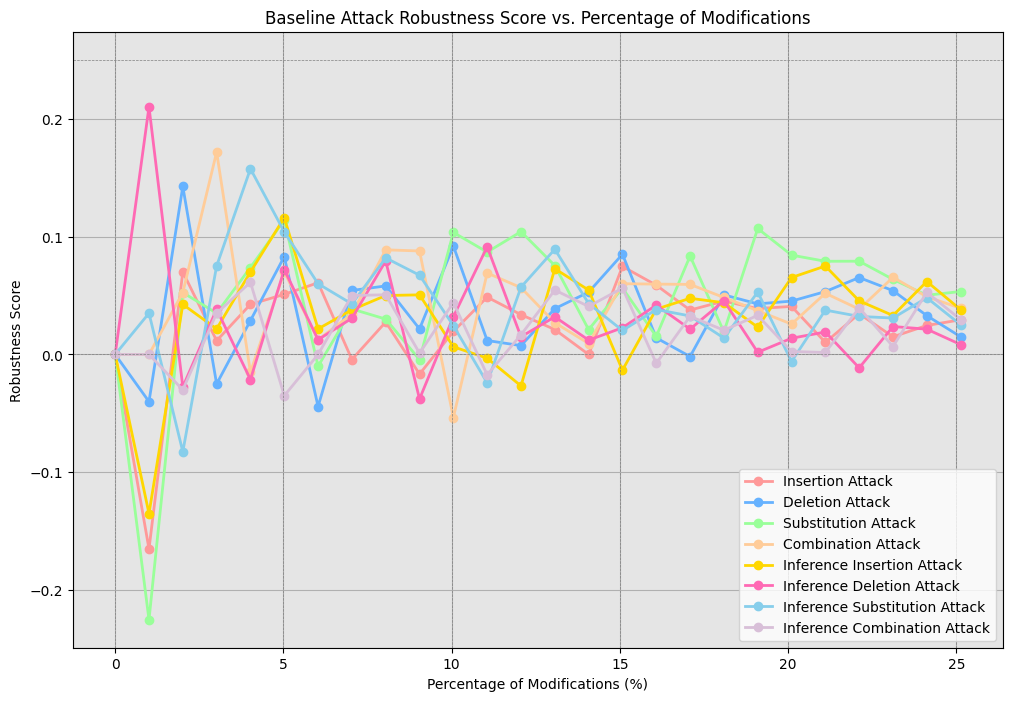

In [20]:
plt.figure(figsize=(12, 8))
colors = [
    '#FF9999', '#66B2FF', '#99FF99', '#FFCC99',
    '#FFD700', '#FF69B4', '#87CEEB', '#D8BFD8'
]

for i, (attack_type, scores) in enumerate(robustness_scores.items()):
    percentage_modifications = [(modifications / total_tokens) * 100 for modifications in n_modifications]
    plt.plot(percentage_modifications, scores, 
             label=f'{attack_type.replace("_", " ").title()} Attack',
             color=colors[i % len(colors)],
             marker='o',
             linewidth=2,
             markersize=6)

plt.title('Baseline Attack Robustness Score vs. Percentage of Modifications')
plt.xlabel('Percentage of Modifications (%)')
plt.ylabel('Robustness Score')
plt.legend()
plt.grid(True)

for x in np.arange(min(percentage_modifications), max(percentage_modifications) + 1, 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)
for y in np.arange(0, max(max(scores) for scores in robustness_scores.values()) + 0.25, 0.25):
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5)
rect = plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.2, transform=plt.gca().transAxes, zorder=-1)
plt.gca().add_patch(rect)
plt.show()

In [21]:
n_modifications = list(range(0, 51, 2))

z_score_results = {'whitespace': [], 'add_char': [], 'combination': [], 'inference_whitespace': [], 'inference_add_char': [], 'inference_combination': []}
robustness_scores = {'whitespace': [], 'add_char': [], 'combination': [], 'inference_whitespace': [], 'inference_add_char': [], 'inference_combination': []}

alteration = DiscreteAlterations()

def evaluate_discrete_attack(attack_type, n_edits, inference=False):
    if attack_type == 'whitespace':
        attacked_text = alteration.add_whitespace(content, n_edits, inference=inference)
    elif attack_type == 'add_char':
        attacked_text = alteration.add_char(content, n_edits, inference=inference)
    elif attack_type == 'combination':
        attacked_text = alteration.combination_modify_text(content, whitespace_n_edits=n_edits//2, white_space_inference=inference, add_char_n_edits=n_edits//2, add_char_inference=inference)
    return attacked_text


for n in n_modifications:
    print(n)
    for attack_type in ['whitespace', 'add_char', 'combination']:
        print(attack_type)

        attacked_text = evaluate_discrete_attack(attack_type, n)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        print('non-inference detection finished')

        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[attack_type].append(z_score)
        if n > 0:
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0
        robustness_scores[attack_type].append(robustness_score)

        inference_attack_type = f'inference_{attack_type}'
        attacked_text = evaluate_discrete_attack(attack_type, n, inference=True)
        attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
        print('inference detection finished')
        
        for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
        z_score_results[inference_attack_type].append(z_score)
        if n > 0:
            robustness_score = (original_z_score - z_score) / n
        else:
            robustness_score = 0
        robustness_scores[inference_attack_type].append(robustness_score)

0
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inference detection finished
combination
non-inference detection finished
inference detection finished
2
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inference detection finished
combination
non-inference detection finished
inference detection finished
4
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inference detection finished
combination
non-inference detection finished
inference detection finished
6
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inference detection finished
combination
non-inference detection finished
inference detection finished
8
whitespace
non-inference detection finished
inference detection finished
add_char
non-inference detection finished
inf

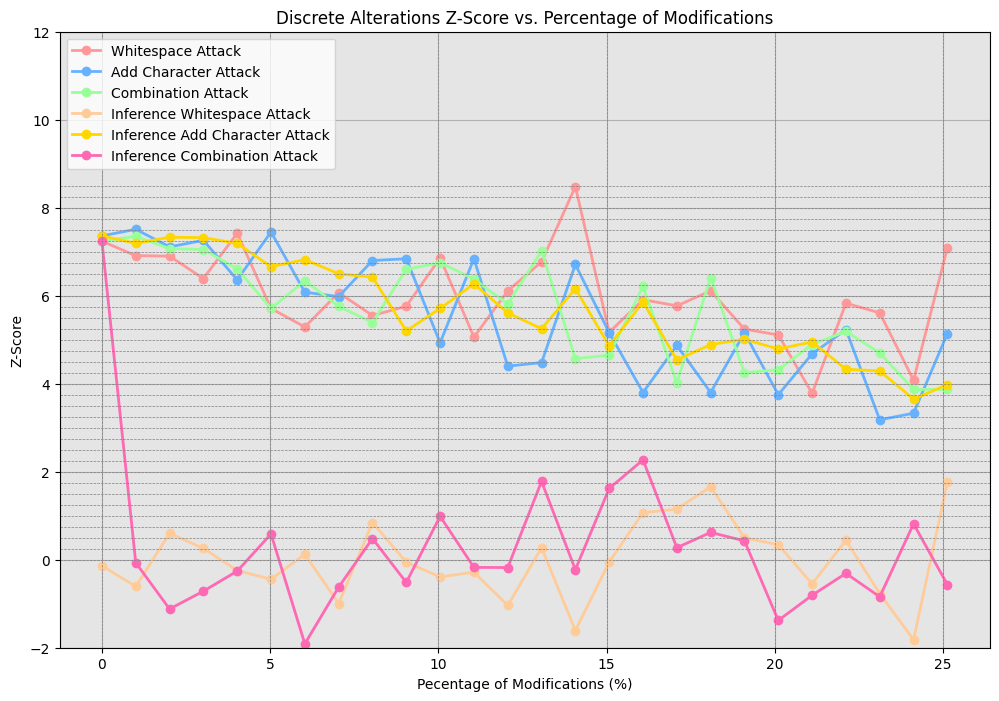

In [22]:
plt.figure(figsize=(12, 8))
label_map = {
    'add_char': 'Add Character',
    'inference_add_char': 'Inference Add Character'
}
for i, (attack_type, z_scores) in enumerate(z_score_results.items()):
    percentage_modifications = [(modifications / total_tokens) * 100 for modifications in n_modifications]
    plt.plot(percentage_modifications, z_scores, 
             label = label_map.get(attack_type, attack_type.replace("_", " ").title()) + " Attack",
             color=colors[i % len(colors)],  
             marker='o', 
             linewidth=2,  
             markersize=6)  
plt.ylim(-2, 12)
plt.title('Discrete Alterations Z-Score vs. Percentage of Modifications')
plt.xlabel('Pecentage of Modifications (%)')
plt.ylabel('Z-Score')
plt.legend(loc='upper left')
plt.grid(True)

for x in np.arange(min(percentage_modifications), max(percentage_modifications) + 1, 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)
for y in np.arange(0, max(max(z_scores) for z_scores in z_score_results.values()) + 0.25, 0.25):
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5)
rect = plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.2, transform=plt.gca().transAxes, zorder=-1)
plt.gca().add_patch(rect)
plt.show()

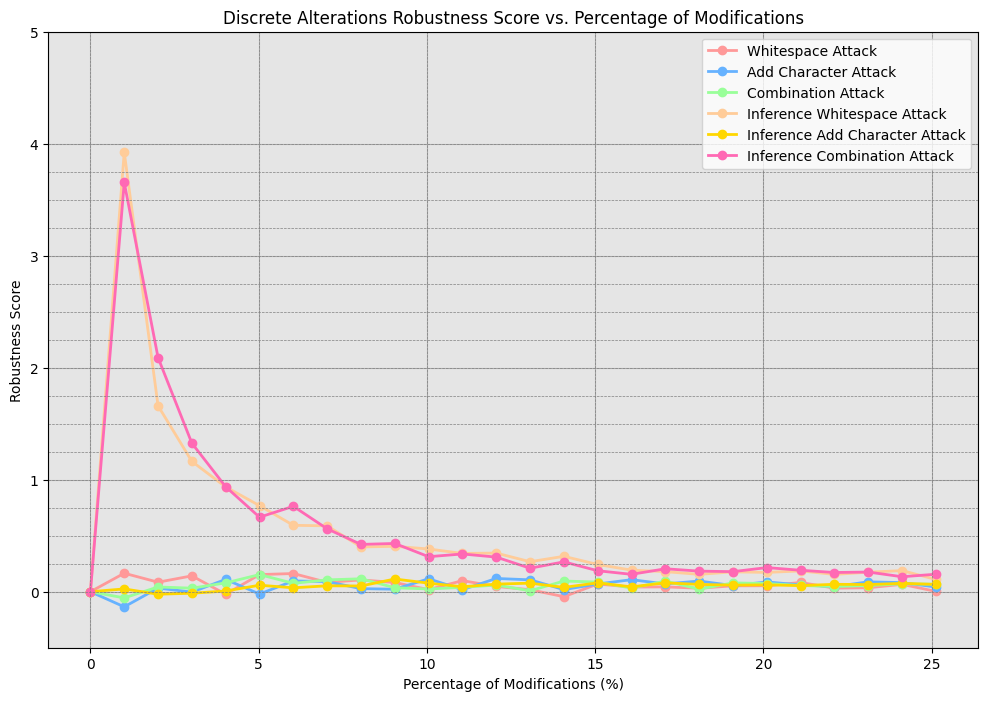

In [23]:
plt.figure(figsize=(12, 8))
for i, (attack_type, scores) in enumerate(robustness_scores.items()):
    label = label_map.get(attack_type, attack_type.replace("_", " ").title()) + " Attack" 
    percentage_modifications = [(modifications / total_tokens) * 100 for modifications in n_modifications]
    plt.plot(percentage_modifications, scores,
             label=label, 
             color=colors[i % len(colors)],  
             marker='o', 
             linewidth=2,
             markersize=6)
plt.ylim(-0.5, 5)
plt.title('Discrete Alterations Robustness Score vs. Percentage of Modifications')
plt.xlabel('Percentage of Modifications (%)')
plt.ylabel('Robustness Score')
plt.legend(loc='upper right') 
plt.grid(True)

for x in np.arange(min(percentage_modifications), max(percentage_modifications) + 1, 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)
for y in np.arange(0, max(max(scores) for scores in robustness_scores.values()) + 0.25, 0.25):
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5)
rect = plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.2, transform=plt.gca().transAxes, zorder=-1)
plt.gca().add_patch(rect)
plt.show()

In [24]:
n_modifications = list(range(0, 51, 2))

z_score_results = {'tokenization': [], 'inference_tokenization': []}
robustness_scores = {'tokenization': [], 'inference_tokenization': []}

tokenization = TokenizationAttack()

def evaluate_tokenization_attack(n_edits, inference=False):
    attacked_text = tokenization.tokenization_attack(content, n_edits, inference=inference)
    return attacked_text


for n in n_modifications:
    print(n)
    attacked_text = evaluate_tokenization_attack(n)
    attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
    print('detected non-inference')
    for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
    z_score_results['tokenization'].append(z_score)
    if n > 0:
        robustness_score = (original_z_score - z_score) / n
    else:
        robustness_score = 0
    robustness_scores['tokenization'].append(robustness_score)

    attacked_text = evaluate_tokenization_attack(n, inference=True)
    attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)
    print('detected inference')
    for item in attacked_detection_result:
            if len(item) > 0:
                if item[0] == 'z-score':
                    z_score = float(item[1])
                    break
    z_score_results['inference_tokenization'].append(z_score)
    if n > 0:
        robustness_score = (original_z_score - z_score) / n
    else:
        robustness_score = 0
    robustness_scores['inference_tokenization'].append(robustness_score)

0
detected non-inference
detected inference
2
detected non-inference
detected inference
4
detected non-inference
detected inference
6
detected non-inference
detected inference
8
detected non-inference
detected inference
10
detected non-inference
detected inference
12
detected non-inference
detected inference
14
detected non-inference
detected inference
16
detected non-inference
detected inference
18
detected non-inference
detected inference
20
detected non-inference
detected inference
22
detected non-inference
detected inference
24
detected non-inference
detected inference
26
detected non-inference
detected inference
28
detected non-inference
detected inference
30
detected non-inference
detected inference
32
detected non-inference
detected inference
34
detected non-inference
detected inference
36
detected non-inference
detected inference
38
detected non-inference
detected inference
40
detected non-inference
detected inference
42
detected non-inference
detected inference
44
detected non

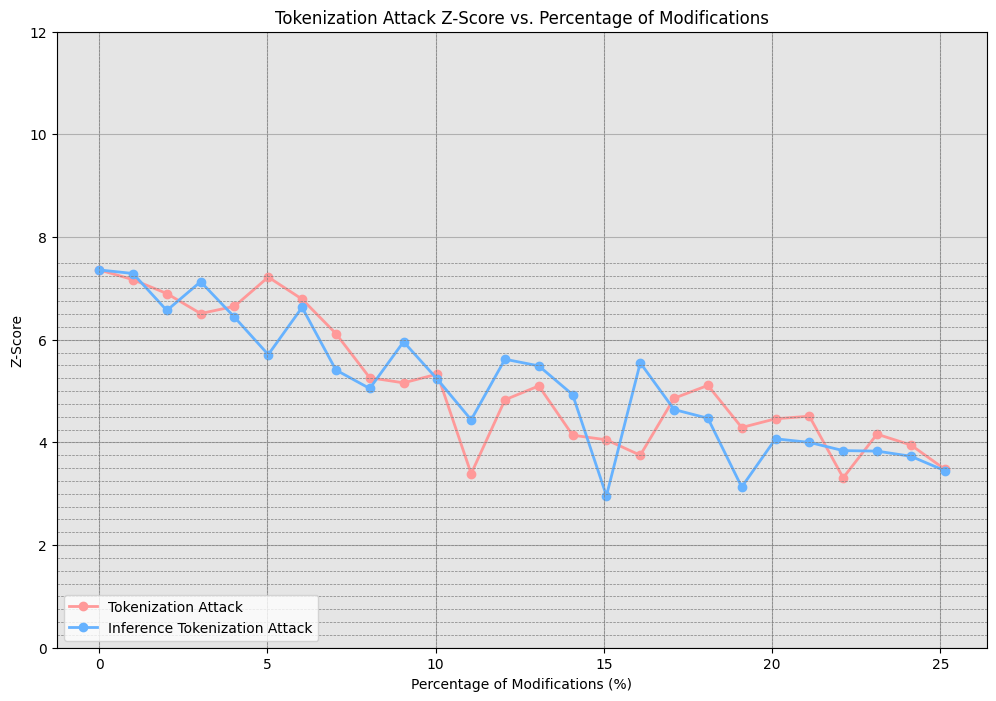

In [25]:
plt.figure(figsize=(12, 8))
for i, (attack_type, z_scores) in enumerate(z_score_results.items()):
    percentage_modifications = [(modifications / total_tokens) * 100 for modifications in n_modifications]
    plt.plot(percentage_modifications, z_scores, 
             label=f'{attack_type.replace("_", " ").title()} Attack',
             color=colors[i % len(colors)], 
             marker='o',
             linewidth=2,
             markersize=6)
plt.ylim(0, 12)
plt.title('Tokenization Attack Z-Score vs. Percentage of Modifications')
plt.xlabel('Percentage of Modifications (%)')
plt.ylabel('Z-Score')
plt.legend(loc='lower left')
plt.grid(True)

for x in np.arange(min(percentage_modifications), max(percentage_modifications) + 1, 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)
for y in np.arange(0, max(max(z_scores) for z_scores in z_score_results.values()) + 0.25, 0.25):
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5)
rect = plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.2, transform=plt.gca().transAxes, zorder=-1)
plt.gca().add_patch(rect)
plt.show()

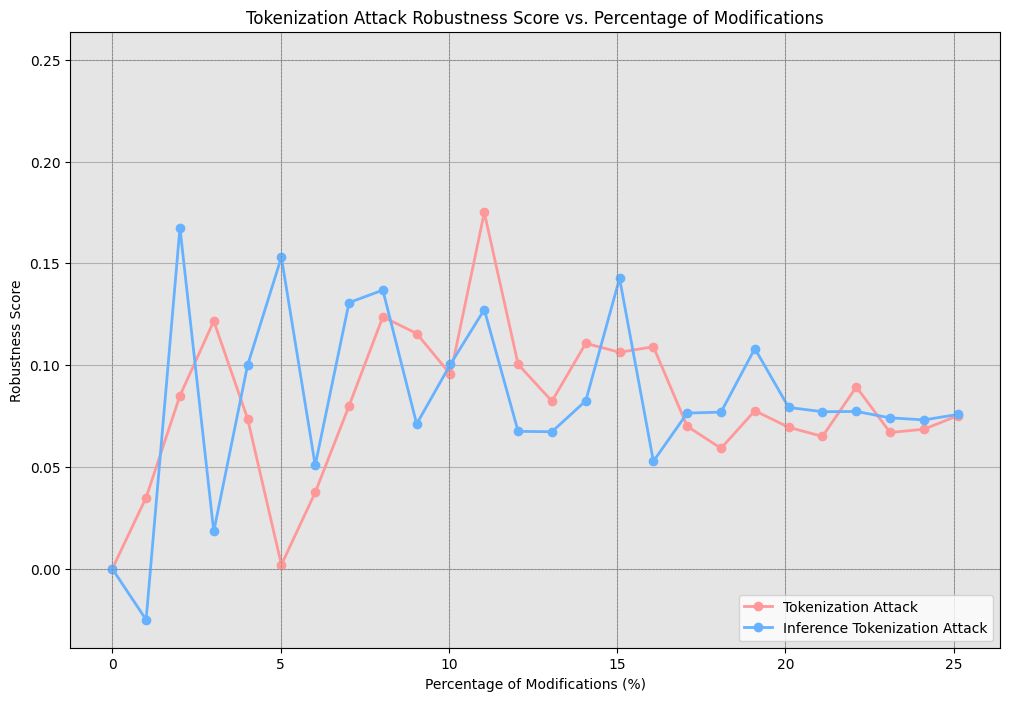

In [26]:
plt.figure(figsize=(12, 8))
for i, (attack_type, scores) in enumerate(robustness_scores.items()):
    percentage_modifications = [(modifications / total_tokens) * 100 for modifications in n_modifications]
    plt.plot(percentage_modifications, scores, 
             label=f'{attack_type.replace("_", " ").title()} Attack',
             color=colors[i % len(colors)],
             marker='o', 
             linewidth=2,  
             markersize=6)  

plt.title('Tokenization Attack Robustness Score vs. Percentage of Modifications')
plt.xlabel('Percentage of Modifications (%)')
plt.ylabel('Robustness Score')
plt.legend(loc='lower right')
plt.grid(True)

for x in np.arange(min(percentage_modifications), max(percentage_modifications) + 1, 5):
    plt.axvline(x=x, color='grey', linestyle='--', linewidth=0.5)
for y in np.arange(0, max(max(scores) for scores in robustness_scores.values()) + 0.25, 0.25):
    plt.axhline(y=y, color='grey', linestyle='--', linewidth=0.5)
rect = plt.Rectangle((0, 0), 1, 1, color='grey', alpha=0.2, transform=plt.gca().transAxes, zorder=-1)
plt.gca().add_patch(rect)
plt.show()

In [4]:
access_token = os.environ.get('HUGGINGFACEHUB_API_TOKEN')

paraphraser = ParaphrasingAttack(access_token=access_token)

attacked_text = paraphraser.rephrase(content)
non_inference_attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)


attacked_text = paraphraser.rephrase(content, topic='sports', inference=True)
relevant_inference_attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)

attacked_text = paraphraser.rephrase(content, topic='health', inference=True)
similar_inference_attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)

attacked_text = paraphraser.rephrase(content, topic='technology', inference=True)
non_relevant_inference_attacked_detection_result = detect(input_prompt, attacked_text, args, device=device, tokenizer=tokenizer)


print(f'Unmodified Watermarked Text Metrics: {without_watermark_detection_result}')
print(f'Generic Paraphrasing: {non_inference_attacked_detection_result}')
print(f'Inference with Correct Topic Paraphrasing: {relevant_inference_attacked_detection_result}')
print(f'Inference with Similar Topic Paraphrasing: {similar_inference_attacked_detection_result}')
print(f'Inference with Incorrect Topic Paraphrasing: {non_relevant_inference_attacked_detection_result}')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/alexandernemecek/.cache/huggingface/token
Login successful
Unmodified Watermarked Text Metrics: [['Tokens Counted (T)', '199'], ['# Tokens in Greenlist', '94'], ['Fraction of T in Greenlist', '47.2%'], ['z-score', '7.24'], ['p value', '2.18e-13'], ['z-score Threshold', '2.5'], ['Prediction', 'Watermarked'], ['Confidence', '100.000%'], []]
Generic Paraphrasing: [['Tokens Counted (T)', '90'], ['# Tokens in Greenlist', '27'], ['Fraction of T in Greenlist', '30.0%'], ['z-score', '1.1'], ['p value', '0.137'], ['z-score Threshold', '2.5'], ['Prediction', 'Human/Unwatermarked'], []]
Inference with Correct Topic Paraphrasing: [['Tokens Counted (T)', '84'], ['# Tokens in Greenlist', '29'], ['Fraction 